In [4]:
rm(list=ls())
setwd('G:/Billfish/VD_FOV_3Dgenome/RNA_Seq/DEG/Fov7_Glr19_J668')
library(DESeq2)

## Load dataset and make metadata
counts = read.table("GSE133624_reads-count-all-sample.txt", header=1, row.names=1)
meta = sapply(colnames(counts), function (x) substring(x,1,1))
meta = data.frame(meta)

colnames(meta) = c("Condition")

dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = meta,
                              design= ~ Condition)

# ## Prefiltering
filt <- rowSums(counts(dds) < 10) > dim(meta)[1]*0.9
print(dim(meta)[1]*0.9)
dds <- dds[!filt,]

## Perform DESeq2()
dds = DESeq(dds)
res = results(dds, pAdjustMethod = "bonferroni")

## apply variance stabilizing transformation
v = vst(dds, blind=FALSE)
vsted = assay(v)
# Plot PCA of VST values


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

    windows


Loading required package: GenomicRanges

Loading required p

[1] 58.5


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1352 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



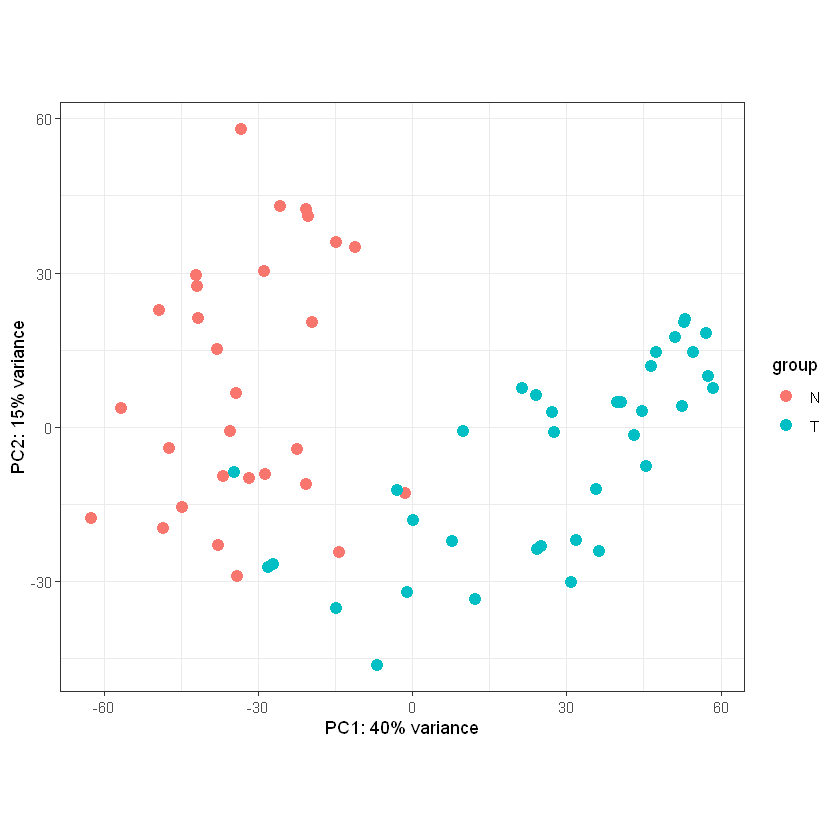

In [16]:
library(ggplot2)
DESeq2::plotPCA(v, intgroup="Condition")+
    theme_bw()

In [5]:
## Define the input genes, and use clusterProfiler::bitr to convert the ID.
library(org.Hs.eg.db)
library(DOSE)
sig = subset(res, padj<0.05)
cand.entrez = clusterProfiler::bitr(rownames(sig), fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)$ENTREZID

## Perform enrichment analysis (ORA)
pway = ReactomePA::enrichPathway(gene = cand.entrez)
pwayGO = clusterProfiler::enrichGO(cand.entrez, ont = "BP", OrgDb = org.Hs.eg.db)

print(pwayGO)
## Convert to SYMBOL
pway = setReadable(pway, OrgDb=org.Hs.eg.db)
pwayGO = setReadable(pwayGO, OrgDb=org.Hs.eg.db)
print(pway)
## Store the similarity
pway = enrichplot::pairwise_termsim(pwayGO)
print(pway)
## Define including samples
incSample = rownames(subset(meta, Condition=="T"))

allEntrez = clusterProfiler::bitr(rownames(res), fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)
res$ENSEMBL <- rownames(res)
lfc <- merge(data.frame(res), allEntrez, by="ENSEMBL")
lfc <- lfc[order(lfc$log2FoldChange, decreasing=TRUE),]
geneList <- lfc$log2FoldChange
names(geneList) <- lfc$ENTREZID

pwayGSE <- ReactomePA::gsePathway(geneList)
sigpway <- subset(pway@result, p.adjust<0.05)
paste(mean(sigpway$Count), sd(sigpway$Count))

Loading required package: AnnotationDbi





DOSE v3.22.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(rownames(sig), fromType = "ENSEMBL", toType = "ENTREZID", :
"13.35% of input gene IDs are fail to map..."


#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 BP 
#...@keytype 	 ENTREZID 
#...@gene 	 chr [1:3094] "55732" "4800" "54467" "79007" "204" "2288" "23028" "126393" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...516 enriched terms found
'data.frame':	516 obs. of  9 variables:
 $ ID         : chr  "GO:0006260" "GO:0006261" "GO:0007059" "GO:0140014" ...
 $ Description: chr  "DNA replication" "DNA-templated DNA replication" "chromosome segregation" "mitotic nuclear division" ...
 $ GeneRatio  : chr  "100/2606" "69/2606" "113/2606" "95/2606" ...
 $ BgRatio    : chr  "280/18800" "159/18800" "348/18800" "293/18800" ...
 $ pvalue     : num  1.77e-20 8.01e-20 3.06e-19 2.46e-16 7.53e-16 ...
 $ p.adjust   : num  1.08e-16 2.45e-16 6.25e-16 3.76e-13 9.22e-13 ...
 $ qvalue     : num  9.02e-17 2.05e-16 5.22e-16 3.14e-13 7.69e-13 ...
 $ geneID     : chr  "3980/10926/4784/5980/1663/4361/5982/5888/10721/55388/4171/54962/9984/4998/23594/8318/990/5427/9837/79913/9767/4

'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(rownames(res), fromType = "ENSEMBL", toType = "ENTREZID", :
"20.2% of input gene IDs are fail to map..."
preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.73% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in fgseaMultilevel(...):
"For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation."
leading edge analysis...

done...



[1] "37.7635658914729 26.7635150520132"

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Warning message in averaged.network.backend(strength = strength, threshold = threshold):
"arc RFC3 -> GINS4 would introduce cycles in the graph, ignoring."
Warning message in averaged.network.backend(strength = strength, threshold = threshold):
"arc RAD51 -> POLQ would introduce cycles in the graph, ignoring."
Warning message in cextend(av, strict = FALSE):
"no consistent extension of av is possible."
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family not found in Windows font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not fo

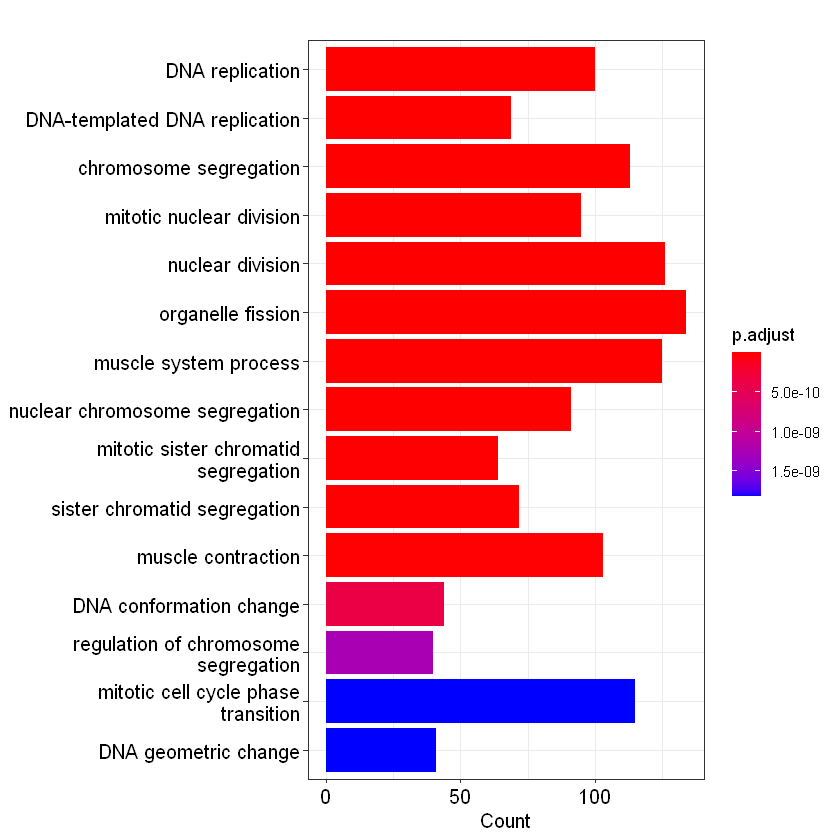

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Warning message in averaged.network.backend(strength = strength, threshold = threshold):
"arc RFC3 -> GINS4 would introduce cycles in the graph, ignoring."
Warning message in averaged.network.backend(strength = strength, threshold = threshold):
"arc RAD51 -> POLQ would introduce cycles in the graph, ignoring."
Warning message in cextend(av, strict = FALSE):
"no consistent extension of av is possible."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

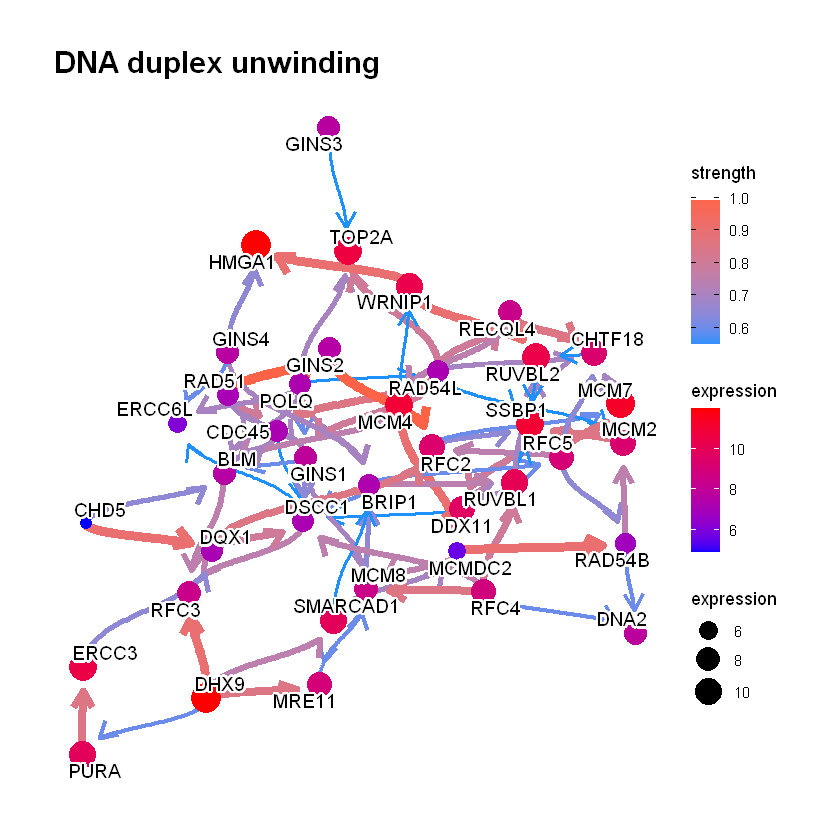

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 

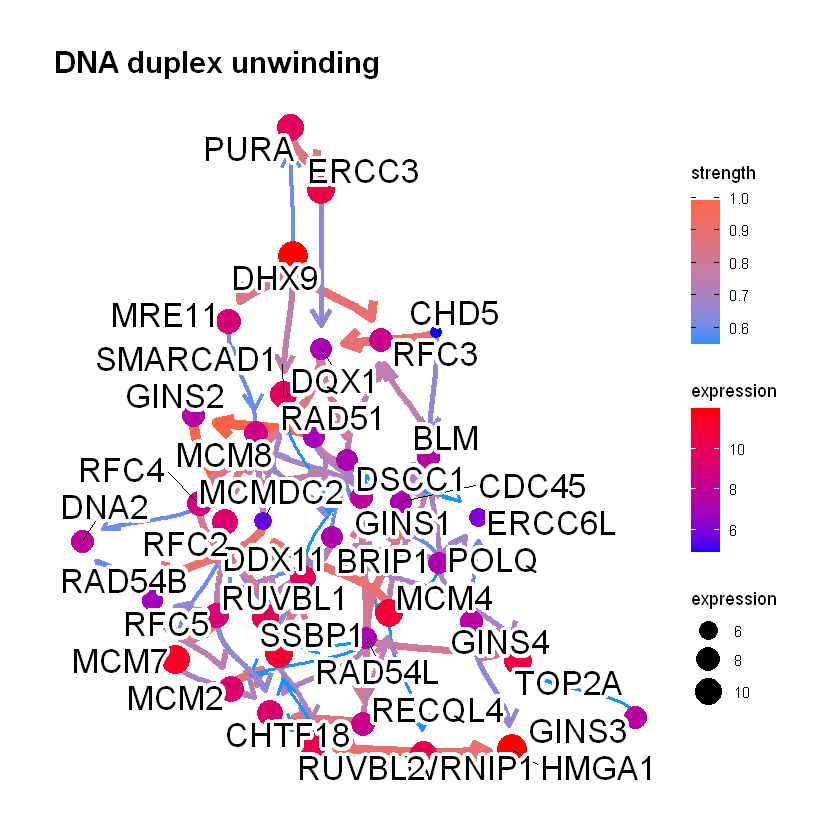

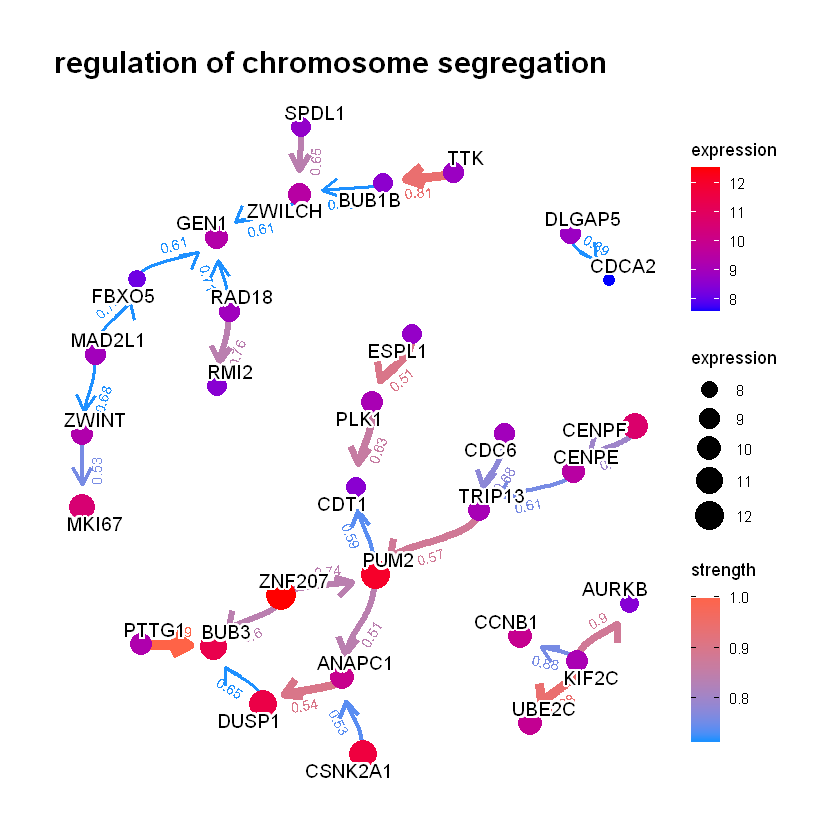

In [6]:
barplot(pway, showCategory = 15)
library(CBNplot)
#使用bngeneplot函数绘图
bngeneplot(results = pway, exp = vsted, pathNum = 17)
#Change the label for the better readability.
bngeneplot(results = pway, exp = vsted, pathNum = 17, labelSize=7, shadowText=TRUE)

# Show the confidence of direction
bngeneplot(results = pway,
           exp = vsted,
           expSample = incSample,
           pathNum = 13, R = 50, showDir = T,
           convertSymbol = T,
           expRow = "ENSEMBL",
           strThresh = 0.7)

In [51]:
print(incSample)
print(pway)
print(vsted)

 [1] "T0156" "T0453" "T0466" "T0474" "T0531" "T0555" "T0565" "T0982" "T1037"
[10] "T1067" "T1495" "T1664" "T2224" "T2226" "T2771" "T2297" "T2347" "T2644"
[19] "T2759" "T2804" "T3138" "T3143" "T3196" "T3282" "T3357" "T3371" "T3403"
[28] "T3451" "T3515" "T3560" "T3614" "T3635" "T3660" "T3740" "T3750" "T3800"
#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 BP 
#...@keytype 	 ENTREZID 
#...@gene 	 chr [1:3094] "55732" "4800" "54467" "79007" "204" "2288" "23028" "126393" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...516 enriched terms found
'data.frame':	516 obs. of  9 variables:
 $ ID         : chr  "GO:0006260" "GO:0006261" "GO:0007059" "GO:0140014" ...
 $ Description: chr  "DNA replication" "DNA-templated DNA replication" "chromosome segregation" "mitotic nuclear division" ...
 $ GeneRatio  : chr  "100/2606" "69/2606" "113/2606" "95/2606" ...
 $ BgRatio    : chr  "280/18800" "159/18800" "348/18800" "293/18800" ...
 $ pvalue     : num  1.77e-20 8.01e

In [ ]:
bnpathplot(results = pway,
           exp = vsted,
           expSample = incSample,
           nCategory = 30,
           R = 10,
           labelSize=5,
           expRow = "ENSEMBL")

In [ ]:
bnpathplot(results = pway,
           exp = vsted,
           expSample = incSample,
           nCategory = 10,
           R = 5,
           expRow = "ENSEMBL")

In [ ]:
df <- bngeneplot(results = pway,
           exp = vsted,
           expSample = incSample,
           pathNum = 13, R = 50, showDir = T,
           convertSymbol = T,
           expRow = "ENSEMBL",
           strThresh = 0.7)

print(df)



In [7]:
library(knitr)
library(magrittr)
library(dplyr)
cl <- parallel::makeCluster(6)
print(cl)
comparePlot <- bngeneplot(results = pway,
                          exp = vsted, cl=cl, strType="normal",
                          pathNum = 15, R = 50, returnNet=T,
                          shadowText = TRUE)

kable(comparePlot$str%>%
    filter(direction>0.5) %>%
    arrange(desc(strength)) %>%
    head())


Attaching package: 'magrittr'


The following object is masked from 'package:GenomicRanges':

    subtract



Attaching package: 'dplyr'


The following object is masked from 'package:AnnotationDbi':

    select


The following object is masked from 'package:Biobase':

    combine


The following object is masked from 'package:matrixStats':

    count


The following objects are masked from 'package:GenomicRanges':

    intersect, setdiff, union


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    int

socket cluster with 6 nodes on host 'localhost'


'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Warning message in averaged.network.backend(strength = strength, threshold = threshold):
"arc CHTF18 -> RUVBL2 would introduce cycles in the graph, ignoring."
Warning message in averaged.network.backend(strength = strength, threshold = threshold):
"arc DSCC1 -> RFC3 would introduce cycles in the graph, ignoring."




|from   |to     |  strength| direction|
|:------|:------|---------:|---------:|
|CHD5   |DQX1   | 0.9814815| 0.7569444|
|DQX1   |RFC2   | 0.9444444| 0.8680556|
|GINS2  |RFC2   | 0.9259259| 0.9606481|
|RAD51  |POLQ   | 0.9074074| 0.6577381|
|MCM7   |MTERF1 | 0.9074074| 0.6200397|
|MCMDC2 |RAD54B | 0.9074074| 0.8141534|

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns





|from   |to     |  strength| direction|
|:------|:------|---------:|---------:|
|BUB3   |PTTG1  | 1.0000000| 0.6666667|
|ANAPC1 |DUSP1  | 0.9629630| 0.5115741|
|CENPF  |CENPE  | 0.9444444| 0.8280423|
|KIF2C  |UBE2C  | 0.9444444| 0.9880952|
|SPDL1  |ZWILCH | 0.9259259| 0.6679894|
|KIF2C  |AURKB  | 0.9259259| 0.9814815|

$plot


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"


$str
        from      to  strength  direction
1     ZNF207   SPDL1 0.2962963 0.73611111
2     ZNF207    PUM2 0.8703704 0.78587963
3     ZNF207   RAD18 0.3888889 0.62777778
4     ZNF207  TRIP13 0.1481481 0.50000000
5     ZNF207   NDC80 0.2777778 0.57777778
6     ZNF207    CDC6 0.3888889 0.72222222
7     ZNF207 CSNK2A1 0.2592593 0.42777778
8     ZNF207   FBXO5 0.3703704 0.90000000
9     ZNF207     TTK 0.1851852 0.45833333
10    ZNF207   CENPF 0.1481481 0.69444444
11    ZNF207   DUSP1 0.2222222 0.41666667
12    ZNF207   ZWINT 0.2962963 0.75000000
13    ZNF207   XRCC3 0.2592593 0.94444444
14    ZNF207  DLGAP5 0.3148148 0.77500000
15    ZNF207   CCNB1 0.2407407 0.87500000
16    ZNF207    PUM1 0.1481481 0.22222222
17    ZNF207   ESPL1 0.3333333 0.63888889
18    ZNF207   CENPE 0.4629630 0.86111111
19    ZNF207   KIF2C 0.2037037 0.41666667
20    ZNF207 HORMAD1 0.1666667 0.31944444
21    ZNF207   MKI67 0.2962963 0.91666667
22    ZNF207  ANAPC1 0.4814815 0.58888889
23    ZNF207    BUB3 0.70370

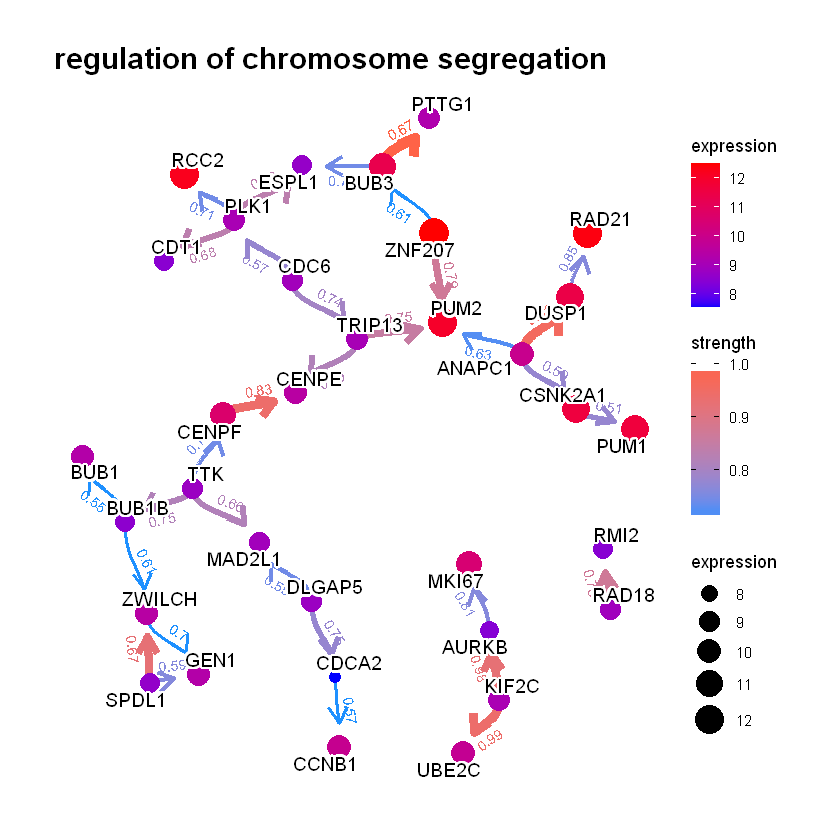

In [90]:
df <- bngeneplot(results = pway,
           exp = vsted,
           expSample = incSample, cl=cl,
           pathNum = 13, R = 50, showDir = T,
           expRow = "ENSEMBL",returnNet=T,
           strThresh = 0.7)
kable(df$str%>%
    filter(direction>0.5) %>%
    arrange(desc(strength)) %>%
    head())
print(df)

In [ ]:
bngeneplot(results = pway,
           exp = vsted,
           pathNum = 5)

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 BP 
#...@keytype 	 ENTREZID 
#...@gene 	 chr [1:3094] "55732" "4800" "54467" "79007" "204" "2288" "23028" "126393" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...516 enriched terms found
'data.frame':	516 obs. of  9 variables:
 $ ID         : chr  "GO:0006260" "GO:0006261" "GO:0007059" "GO:0140014" ...
 $ Description: chr  "DNA replication" "DNA-templated DNA replication" "chromosome segregation" "mitotic nuclear division" ...
 $ GeneRatio  : chr  "100/2606" "69/2606" "113/2606" "95/2606" ...
 $ BgRatio    : chr  "280/18800" "159/18800" "348/18800" "293/18800" ...
 $ pvalue     : num  1.77e-20 8.01e-20 3.06e-19 2.46e-16 7.53e-16 ...
 $ p.adjust   : num  1.08e-16 2.45e-16 6.25e-16 3.76e-13 9.22e-13 ...
 $ qvalue     : num  9.02e-17 2.05e-16 5.22e-16 3.14e-13 7.69e-13 ...
 $ geneID     : chr  "LIG3/DBF4/NFIX/REV3L/DDX11/MRE11/RFC2/RAD51/POLQ/MCM10/MCM2/TIPIN/THOC1/ORC1/ORC6/CDC45/CDC6/POLE2/GINS1/ACTR5/

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Warning message in averaged.network.backend(strength = strength, threshold = threshold):
"arc CDC45 -> BLM would introduce cycles in the graph, ignoring."
Warning message in averaged.network.backend(strength = strength, threshold = threshold):
"arc DSCC1 -> RFC3 would introduce cycles in the graph, ignoring."
Warning message in cextend(av, strict = FALSE):
"no consistent extension of av is possible."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"f

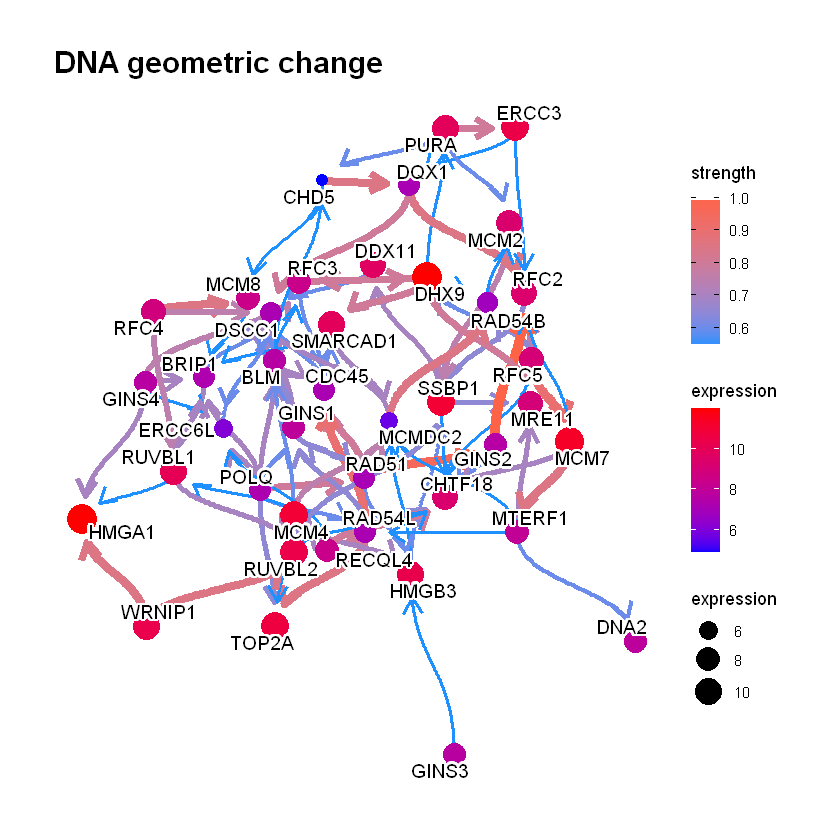

In [19]:
#pway2 = pway[, c('ID', 'Description','GeneRatio','BgRatio','pvalue','p.adjust','qvalue','geneID', 'Count')]
#pway2 = data.frame(pway$ID, pway$Description, pway$GeneRatio)
# pway2 = subset(pway, select=c("ID", 'Description'))
# print(pway2)

# pway2 = select(pway, 'ID', 'Description', 'GeneRatio')
print(pway)

pway2 = pway %>%
  select('ID', 'Description','GeneRatio','BgRatio','geneID')

bngeneplot(results = pway,
           exp = vsted, pathNum = 15,  expRow = "ENSEMBL")

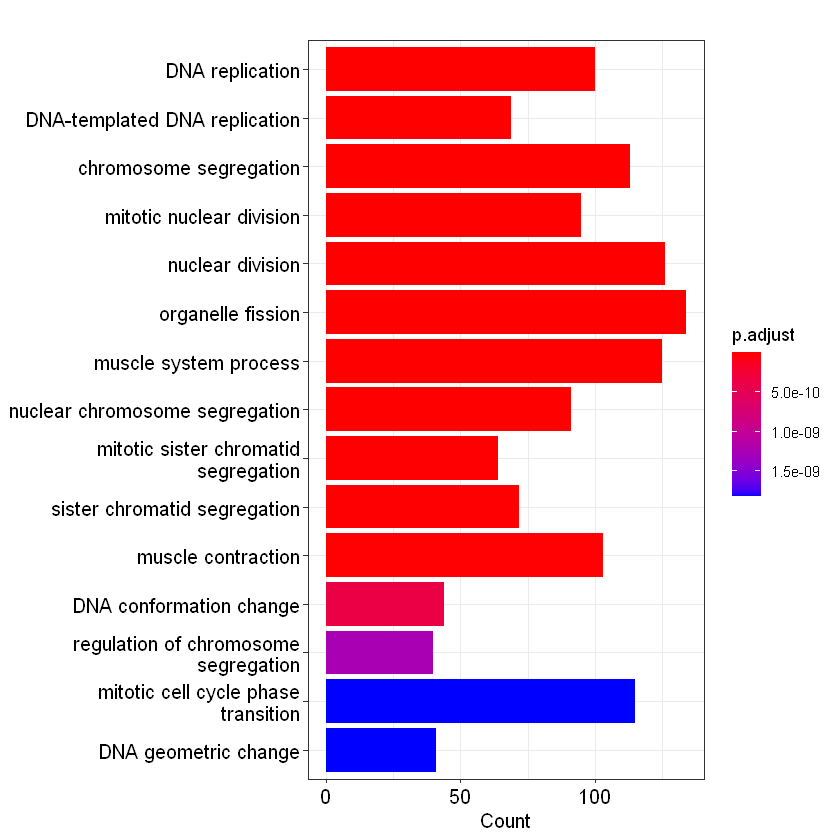

In [21]:
#bngeneplot(results = pway, exp = vsted, pathNum = 15,  expRow = "ENSEMBL")
barplot(pway, showCategory = 15)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1352 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



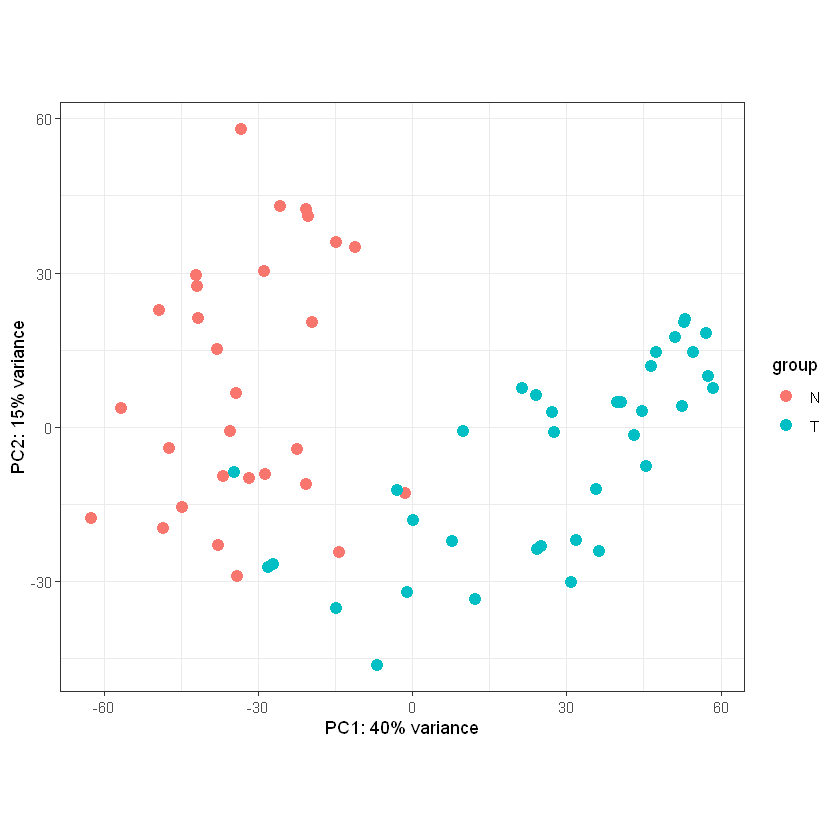

In [23]:
library(DESeq2)
library(ggplot2)

## Load dataset and make metadata
counts = read.table("GSE133624_reads-count-all-sample.txt", header=1, row.names=1)
meta = sapply(colnames(counts), function (x) substring(x,1,1))
meta = data.frame(meta)
colnames(meta) = c("Condition")

dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = meta,
                              design= ~ Condition)
## Prefiltering
filt <- rowSums(counts(dds) < 10) > dim(meta)[1]*0.9
dds <- dds[!filt,]

## Perform DESeq2()
dds = DESeq(dds)
res = results(dds, pAdjustMethod = "bonferroni")

## apply variance stabilizing transformation
v = vst(dds, blind=FALSE)
vsted = assay(v)
## Plot PCA of VST values
DESeq2::plotPCA(v, intgroup="Condition")+
    theme_bw()


In [24]:
## Define the input genes, and use clusterProfiler::bitr to convert the ID.
sig = subset(res, padj<0.05)
cand.entrez = clusterProfiler::bitr(rownames(sig), fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)$ENTREZID

## Perform enrichment analysis (ORA)
pway = ReactomePA::enrichPathway(gene = cand.entrez)
pwayGO = clusterProfiler::enrichGO(cand.entrez, ont = "BP", OrgDb = org.Hs.eg.db)

## Convert to SYMBOL
pway = setReadable(pway, OrgDb=org.Hs.eg.db)
pwayGO = setReadable(pwayGO, OrgDb=org.Hs.eg.db)

## Store the similarity
pway = enrichplot::pairwise_termsim(pway)

## Define including samples
incSample = rownames(subset(meta, Condition=="T"))

allEntrez = clusterProfiler::bitr(rownames(res), fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)
res$ENSEMBL <- rownames(res)
lfc <- merge(data.frame(res), allEntrez, by="ENSEMBL")
lfc <- lfc[order(lfc$log2FoldChange, decreasing=TRUE),]
geneList <- lfc$log2FoldChange
names(geneList) <- lfc$ENTREZID

pwayGSE <- ReactomePA::gsePathway(geneList)
sigpway <- subset(pway@result, p.adjust<0.05)
paste(mean(sigpway$Count), sd(sigpway$Count))

'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(rownames(sig), fromType = "ENSEMBL", toType = "ENTREZID", :
"13.35% of input gene IDs are fail to map..."
'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(rownames(res), fromType = "ENSEMBL", toType = "ENTREZID", :
"20.2% of input gene IDs are fail to map..."
preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.73% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in fgseaMultilevel(...):
"For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argumen

[1] "29.6976744186047 22.0886288379294"

In [28]:
print(incSample)
bnpathplot(results = pway,
           exp = vsted,
           expSample = incSample,
           nCategory = 30,
           R = 10,
           labelSize=5,
           expRow = "ENSEMBL")

 [1] "T0156" "T0453" "T0466" "T0474" "T0531" "T0555" "T0565" "T0982" "T1037"
[10] "T1067" "T1495" "T1664" "T2224" "T2226" "T2771" "T2297" "T2347" "T2644"
[19] "T2759" "T2804" "T3138" "T3143" "T3196" "T3282" "T3357" "T3371" "T3403"
[28] "T3451" "T3515" "T3560" "T3614" "T3635" "T3660" "T3740" "T3750" "T3800"


Warning message in averaged.network.backend(strength = strength, threshold = threshold):
"arc Amplification of signal from the kinetochores -> EML4 and NUDC in mitotic spindle formation would introduce cycles in the graph, ignoring."
ERROR while rich displaying an object: Error in UseMethod("rescale"): no applicable method for 'rescale' applied to an object of class "AsIs"

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype